In [4]:
# ==============================
# 1) Import thư viện
# ==============================
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import emoji
import nltk

from nltk.stem import WordNetLemmatizer
from wordcloud import STOPWORDS as WC_STOPWORDS
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    StratifiedKFold,
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
)

import sys, os
sys.path.append(os.path.abspath("../.."))
from src.preprocessing import preprocess_text_fin

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hung0\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hung0\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# ==============================
# 2) Cấu hình chung
# ==============================
DATA_PATH = "../../data/data.csv"     # thay bằng đường dẫn thực tế
TEXT_COL = "Sentence"
TARGET_COL = "Sentiment"

TEST_SIZE = 0.20
RANDOM_STATE = 42
N_SPLITS = 5


In [6]:
# ==============================
# 2) Load & tiền xử lý dữ liệu
# ==============================
df = pd.read_csv(DATA_PATH)
df["text_clean"] = df[TEXT_COL].apply(preprocess_text_fin)

X_train, X_test, y_train, y_test = train_test_split(
    df["text_clean"],
    df[TARGET_COL],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=df[TARGET_COL],
)

In [16]:
# ==============================
# 3) Pipeline & GridSearchCV
# ==============================
pipe = Pipeline(
    steps=[
        (
            "tfidf",
            TfidfVectorizer(
                ngram_range=(1, 2),
                max_df=0.95,
                min_df=5,
                max_features=10_000,
                sublinear_tf=True,
                norm="l2",
            ),
        ),
        (
            "clf",
            MultinomialNB(alpha=0.5)
        ),
    ]
)

param_grid = {
    "tfidf__ngram_range": [(1,1), (1,2)],           # (1,2) thường tốt với dữ liệu ngắn tài chính
    "tfidf__min_df": [2, 5],                        # tránh min_df = 1 nếu nhiều từ hiếm
    "tfidf__max_df": [0.85, 0.9, 0.95],             # loại bỏ từ quá phổ biến
    "tfidf__max_features": [5_000, 10_000],         # với ~5.8k câu, 5k-10k thường đủ
    "tfidf__sublinear_tf": [True],                  # để giảm bias từ từ hay lặp
    "tfidf__norm": ["l2", None],                    # thường l2 tốt cho phân lớp

    # MultinomialNB params
    "clf__alpha": [1e-3, 1e-2, 0.1, 0.5, 1.0],
    "clf__fit_prior": [True, False],
}

cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=1,
)

In [17]:
# ==============================
# 4) Train + Evaluate
# ==============================
gs.fit(X_train, y_train)

print("Best params:", gs.best_params_)
print("CV best f1_macro:", gs.best_score_)

best = gs.best_estimator_
y_pred = best.predict(X_test)

print("\n=== Test Accuracy:", accuracy_score(y_test, y_pred))
print("=== Test Macro-F1:", f1_score(y_test, y_pred, average="macro"))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
Best params: {'clf__alpha': 0.5, 'clf__fit_prior': False, 'tfidf__max_df': 0.85, 'tfidf__max_features': 5000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__norm': 'l2', 'tfidf__sublinear_tf': True}
CV best f1_macro: 0.6134174731633595

=== Test Accuracy: 0.6621043627031651
=== Test Macro-F1: 0.6118053340515969

Classification Report:
               precision    recall  f1-score   support

    negative       0.36      0.50      0.42       172
     neutral       0.78      0.69      0.73       626
    positive       0.68      0.68      0.68       371

    accuracy                           0.66      1169
   macro avg       0.61      0.63      0.61      1169
weighted avg       0.69      0.66      0.67      1169



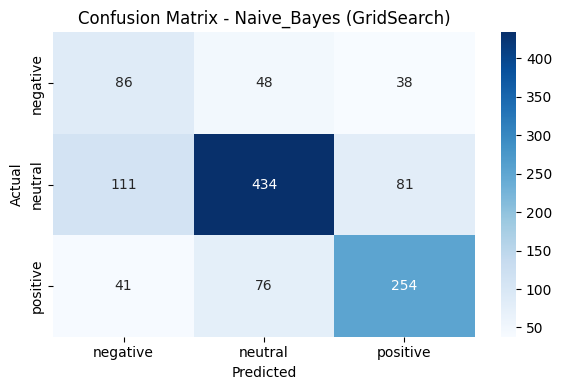

In [20]:
# ==============================
# 5) Confusion Matrix
# ==============================
clf = best.named_steps["clf"]
classes = clf.classes_

cm = confusion_matrix(y_test, y_pred, labels=classes)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=classes,
    yticklabels=classes,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Naive_Bayes (GridSearch)")
plt.tight_layout()
plt.show()

In [22]:
# ==============================
# 6) Top từ/ngữ quan trọng theo lớp
# ==============================
# Lấy TF-IDF và model từ pipeline
tfidf = best.named_steps["tfidf"]
clf = best.named_steps["clf"]

feature_names = tfidf.get_feature_names_out()

# Lặp qua từng class
for i, label in enumerate(clf.classes_):
    coefs = clf.feature_log_prob_[i]  # log-prob của từ thuộc class này
    top_idx = np.argsort(coefs)[-10:][::-1]  # top 10 từ lớn nhất
    top_terms = feature_names[top_idx]
    top_scores = coefs[top_idx]

    print(f"\nTop words for class '{label}':")
    print(", ".join(top_terms))  # in gọn giống bạn yêu cầu


Top words for class 'negative':
currency, eur, mn, profit, eur mn, sale, year, operating, net, loss

Top words for class 'neutral':
will, company, eur, share, said, finland, mn, sale, million, finnish

Top words for class 'positive':
currency, eur, sale, year, mn, profit, company, net, long, will


In [18]:
# ==============================
# 7) Thử nghiệm với nhiều chuỗi
# ==============================

test_sentences = [
    "Dollar falls as traders bet on more rate cuts",
    "Central Europe's FX to get dollar boost, but forint likely to fall from highs",
    "Bulgaria sets price controls as euro transition nears",
    "To make economies work for everyone, we need to put a price on social impact",
    "European shares settle lower as investors gauge mixed earnings, EU-US trade progress",
    "What's in the EU's countermeasures to US tariffs?",
    "Syria is secretly reshaping its economy. The president’s brother is in charge."
]

# Làm sạch
test_clean_list = [preprocess_text_fin(s) for s in test_sentences]

# Vector hóa & dự đoán
tfidf = best.named_steps["tfidf"]
clf   = best.named_steps["clf"]
classes = clf.classes_

X_test_custom = tfidf.transform(test_clean_list)
pred_labels   = clf.predict(X_test_custom)

# Xác suất theo lớp (nếu model hỗ trợ)
has_proba = hasattr(clf, "predict_proba")
pred_probas = clf.predict_proba(X_test_custom) if has_proba else None

# In kết quả từng câu
for i, (raw, clean, pred) in enumerate(zip(test_sentences, test_clean_list, pred_labels), start=1):
    print(f"\n[{i}] Chuỗi gốc: {raw}")
    print(f"    Đã làm sạch: {clean}")
    print(f"    Nhãn dự đoán: {pred}")

    if has_proba:
        probs = pred_probas[i-1]  # thay vì test_sentences.index(raw)
        topk = min(3, len(classes))
        top_idx = np.argsort(probs)[-topk:][::-1]
        print("    Top xác suất:")
        for j in top_idx:
            print(f"      - {classes[j]}: {probs[j]:.4f}")



[1] Chuỗi gốc: Dollar falls as traders bet on more rate cuts
    Đã làm sạch: dollar fall trader bet rate cut
    Nhãn dự đoán: negative
    Top xác suất:
      - negative: 0.7796
      - positive: 0.1141
      - neutral: 0.1063

[2] Chuỗi gốc: Central Europe's FX to get dollar boost, but forint likely to fall from highs
    Đã làm sạch: central europe fx dollar boost, forint likely fall high
    Nhãn dự đoán: positive
    Top xác suất:
      - positive: 0.3930
      - neutral: 0.3606
      - negative: 0.2464

[3] Chuỗi gốc: Bulgaria sets price controls as euro transition nears
    Đã làm sạch: bulgaria set price control euro transition nears
    Nhãn dự đoán: neutral
    Top xác suất:
      - neutral: 0.5980
      - positive: 0.2239
      - negative: 0.1781

[4] Chuỗi gốc: To make economies work for everyone, we need to put a price on social impact
    Đã làm sạch: make economy work everyone, need put price social impact
    Nhãn dự đoán: negative
    Top xác suất:
      - negative: 

In [21]:
import pickle

# Lưu pipeline đã train
with open("../../models/Naive_Bayes/NB_model.pkl", "wb") as f:
    pickle.dump(best, f)

print("✅ Mô hình đã được lưu vào ../../models/Naive_Bayes/NB_model.pkl")

✅ Mô hình đã được lưu vào ../../models/Naive_Bayes/NB_model.pkl
